### Score Class Activation Map
##### Score-CAM is used to explain how KyleNet makes its decisions. The code has been taken and adapted from: https://github.com/tabayashi0117/Score-CAM

##### Score-CAM Procedure (from GitHub source):
###### 1. upsample the output of final conv layer to original input size
###### 2. normalize the raw activation value in each activation map into [0, 1]
###### 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
###### 4. feed masked inputs into CNN model and softmax
###### 5. define weight as the score of target class
###### 6. get final class discriminative localization map as linear weighted combination of all activation maps

In [353]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras_preprocessing.image import img_to_array
from tensorflow.python.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import load_img

##### Load the best experiment from KyleNet

In [354]:
model_path = Path(".").resolve().parent.joinpath("models/Experiment 4.h5")
model = load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 108, 108, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

##### Configuration Options

In [355]:
img_path = "../dataset/COVID-19/137covid_patient1_SR_2_IM00010.png"
img_array = np.array(load_img(img_path), dtype=np.uint8)
final_conv_layer = "conv2d_5"

##### Show Image Function

In [356]:
def show_image(image_array):
    plt.imshow(image_array)
    plt.axis("off")
    plt.show()

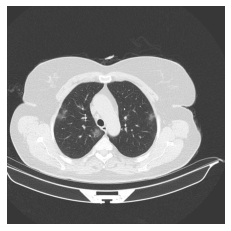

In [357]:
# Show original image
show_image(img_array)

##### ScoreCam Algorithm

In [412]:
def ScoreCam(model, img_array, layer_name, max_N=-1):
    cls = (model.predict(img_array, batch_size=128) > 0.5).astype("int")

    act_map_array = Model(inputs=model.input, outputs=model.get_layer(layer_name).output).predict(img_array)

    # Extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    # 1. Get the input shape and upsample to the original input size
    input_shape = model.layers[0].input_shape[1:]
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]

    # 2. Normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)

    # 3. Project the highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)

        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)

    # 4. Feed the masked inputs into the CNN model and sigmoid
    pred_from_masked_input_array = sigmoid(model.predict(masked_input_array))

    # 5. Define the weight as the score of target class
    weights = pred_from_masked_input_array[:]

    # 6. Get the final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0

    return cam

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

##### Build Heatmap

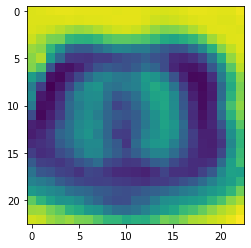

In [413]:
def read_and_preprocess_img(img, size):
    img = load_img(img, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

preprocessed_image_array = read_and_preprocess_img(img_path, size=(224,224))

score_cam = ScoreCam(model, preprocessed_image_array, final_conv_layer)

plt.imshow(score_cam)
plt.show()

##### Super Impose Algorithm

In [414]:
def superimpose(original_img_path, cam, emphasize=False):
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = 1 / (1 + np.exp(-50 * (heatmap-0.5))) # sigmoid
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    hif = 0.8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    return superimposed_img_rgb

In [415]:
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

##### Show All Images

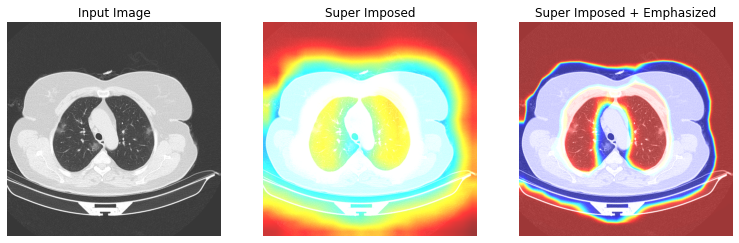

In [416]:
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(13, 11))
ax[0].imshow(img_array)
ax[0].set_title("Input Image")
ax[1].imshow(score_cam_superimposed)
ax[1].set_title("Super Imposed")
ax[2].imshow(score_cam_emphasized)
ax[2].set_title("Super Imposed + Emphasized")

for ax in fig.axes:
    ax.axis("off")

plt.savefig("../images/Score-CAM.png")
plt.show()
